In [1]:
%cd ..
import os
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from skimage import io, transform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.linear import Linear
from src.loss import *
from src.activation import TanH, Sigmoid, Softmax, ReLU, Softplus
from src.encapsulation import Sequential, Optim
np.random.seed(42)

d:\~Perso\Etudes\DAC\NeuralNetworksDIY


jouer avec les hpyerparam
espace latent
les initialisation 
plein de loss 
qu'est ce qui boost les perfs 

# Débruitage d'image plus petite

fashion mnist

In [2]:
def load_data(rootdir, trim: float = 0.5):
    train = pd.read_csv(os.path.join(rootdir, "fashion-mnist_train.csv"))
    y_train = train["label"].values
    X_train = train.drop(columns="label").values

    test = pd.read_csv(os.path.join(rootdir, "fashion-mnist_test.csv"))
    y_test = test["label"].values
    X_test = test.drop(columns="label").values

    trim_train = int(len(X_train) * trim)
    trim_test = int(len(X_test) * trim)
    return (
        X_train[:trim_train, :],
        X_test[:trim_test, :],
        y_train[:trim_train],
        y_test[:trim_test],
    )


rootdir = "./data/fashion-mnist/"
X_train, X_test, y_train, y_test = load_data(rootdir)

y_train_oh = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_oh = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
nb_class = y_train_oh.shape[1]
batch_size = 64


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


<Axes: xlabel='epoch', ylabel='loss'>

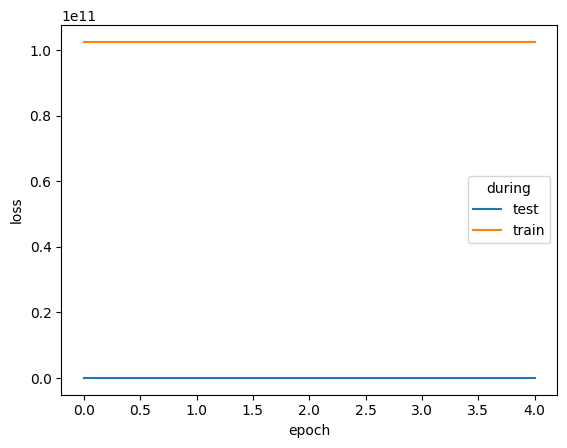

In [8]:
encoder = [
    Linear(784, 64),
    TanH(),
]
decoder = [
    Linear(64, 784),
    Sigmoid()
]
net = Sequential(*(encoder + decoder))
optimizer = Optim(net.reset(), MSELoss(), eps=1e-3)
result_df = optimizer.SGD_eval(
    X_train, X_train, batch_size, 5, test_size=0.33, return_dataframe=True
)

_, ax = plt.subplots()
loss_long_df = pd.melt(
    result_df,
    id_vars="epoch",
    value_vars=["loss_test", "loss_train"],
    value_name="loss",
    var_name="during",
).replace({"loss_test": "test", "loss_train": "train"})
sns.lineplot(loss_long_df, x="epoch", y="loss", hue="during", ax=ax)


In [9]:
optimizer = Optim(net.reset(), MSELoss(), eps=1e-3)
optimizer.SGD(
    X_train, X_train, batch_size, 10
)


100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


array([10350148.02186741, 10350027.75709997, 10350027.57835431,
       10350027.65109794, 10350027.65758858, 10350027.74741023,
       10350027.64532151, 10350027.74876402, 10350027.65540492,
       10350027.75178568])

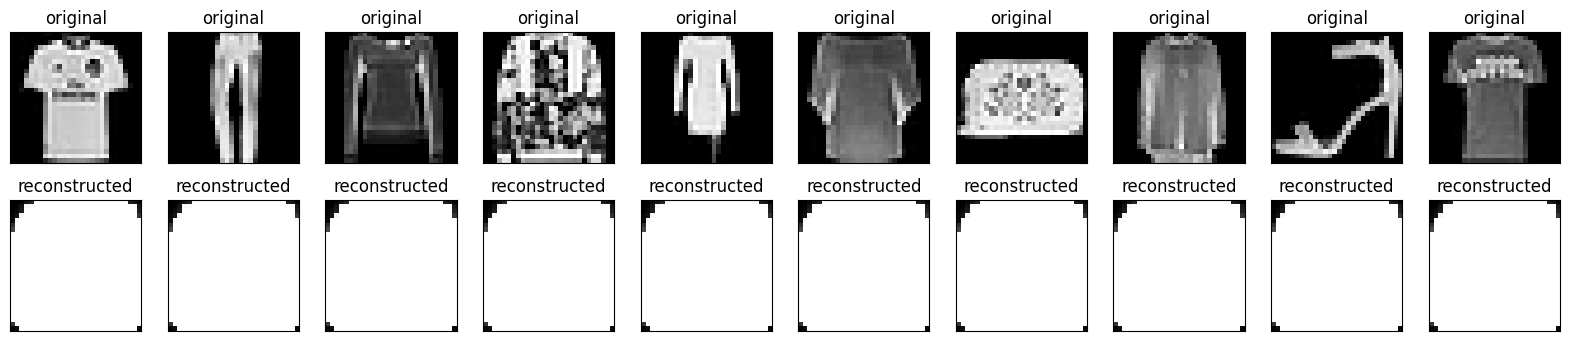

In [10]:
n = 10
decoded_imgs = net.forward(X_test)
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# Débruitage d'image

Dataset : https://www.kaggle.com/datasets/uurdeep/cleaning-dirty-documents-unzipped

In [2]:
def load_data(root_dir):
    size = (540, 420)
    X = []
    for filepath in os.listdir(root_dir + "/X"):
        imgpath = os.path.join(root_dir, "X", filepath)
        image = io.imread(imgpath)
        image = transform.resize(image, size).flatten()
        X.append(image)
    X = np.array(X)

    y = []
    for filepath in os.listdir(root_dir + "/y"):
        imgpath = os.path.join(root_dir, "y", filepath)
        image = io.imread(imgpath)
        image = transform.resize(image, size).flatten()
        y.append(image)
    y = np.array(y)

    return X, y


X, y = load_data("./data/dirty_documents")
print(X.shape)
print(y.shape)

(144, 226800)
(144, 226800)


In [3]:
from src.convolution import *

encoder = [
      Conv1D(3, 1, 16, stride=2),
      ReLU(),
      Conv1D(3, 1, 8, stride=2),
      ReLU()]

decoder = [
  Conv1D(3, 1, 8, stride=2),
  ReLU(),
  Conv1D(3, 1, 16, 2),
  ReLU(),
  Conv1D(3, 1, 1),
  Sigmoid()]


net = Sequential(*(encoder + decoder))
optimizer = Optim(net, MSELoss(), eps=1e-1)
lossList = optimizer.SGD(X[:,:,np.newaxis], y, 144, 10)
print(lossList)
pd.Series(lossList).plot()




  0%|          | 0/10 [00:13<?, ?it/s]


AssertionError: dimension mismatch, y and yhat must of same dimension. Here it is (144, 226800) and (144, 14172, 1)

In [7]:
batch_size = 32
d = 2  # Dim des entrées

X = np.random.random(size=(256, d))
y = np.random.choice([1], size=(256, 1))

encoder = [
    Linear(226800, 226800 // 8),
    TanH(),
    Linear(226800 // 8, 226800 / 16),
    TanH(),
    Linear(226800 / 16, 226800 / 32),
    TanH(),
]
decoder = [
    Linear(226800 / 16, 226800 / 32),
    TanH(),
    Linear(226800 / 8, 226800 / 16),
    TanH(),
    Linear(226800, 226800 / 8),
    Sigmoid(),
]
net = encoder + decoder
optimizer = Optim(net, CrossEntropyLoss(), eps=1e-1)
lossList = optimizer.SGD(X, y, batch_size, 10)
print(lossList)
pd.Series(lossList).plot()


KeyboardInterrupt: 

In [8]:
X.shape

(256, 2)

**A faire avec une convolution**